In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

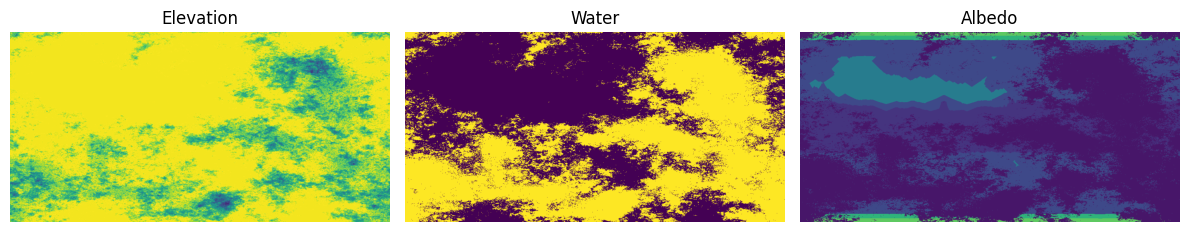

New files:
 - Elevation: proc_planet_2\elevation.npy
 - Water mask: proc_planet_2\water_mask.npy
 - Albedo: proc_planet_2\albedo.npy
 - Preview: proc_planet_2\preview_fixed.png


In [4]:
# ================= PARAMETERS =================
W, H = 1024, 512
ocean_fraction = 0.5
mountain_strength = 0.45
ridge_strength = 0.55
small_scale_strength = 0.15
warp_amp = 0.08
shelf_width = 0.06
snowline = 0.18
lapse_rate = 0.9
seed = 666

np.random.seed(seed)

out_dir = Path('./proc_planet_2')
out_dir.mkdir(parents=True, exist_ok=True)

# =============== UTILS ========================
def spectral_noise(shape, alpha=1.8, seed=None):
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    H, W = shape
    kx = np.fft.fftfreq(W) * W
    ky = np.fft.fftfreq(H) * H
    kx2, ky2 = np.meshgrid(kx, ky)
    k2 = kx2**2 + ky2**2
    amp = 1.0 / (1.0 + k2) ** (alpha / 2.0)
    phase = rng.uniform(0, 2*np.pi, size=(H, W))
    z = amp * (np.cos(phase) + 1j*np.sin(phase))
    field = np.fft.ifft2(z).real
    field = field - field.min()
    field = 2.0 * (field / (field.max() + 1e-12)) - 1.0
    return field

def bilinear_periodic_sample(Z, Xf, Yf):
    H, W = Z.shape
    Xf = np.mod(Xf, W)
    Yf = np.mod(Yf, H)
    x0 = np.floor(Xf).astype(int)
    y0 = np.floor(Yf).astype(int)
    x1 = (x0 + 1) % W
    y1 = (y0 + 1) % H
    sx = Xf - x0
    sy = Yf - y0
    z00 = Z[y0, x0]; z10 = Z[y0, x1]
    z01 = Z[y1, x0]; z11 = Z[y1, x1]
    z0 = z00 * (1 - sx) + z10 * sx
    z1 = z01 * (1 - sx) + z11 * sx
    return z0 * (1 - sy) + z1 * sy

def smoothstep(x, edge0, edge1):
    t = np.clip((x - edge0) / (edge1 - edge0 + 1e-12), 0.0, 1.0)
    return t * t * (3 - 2 * t)

# =============== ELEVATION ====================
cont = spectral_noise((H, W), alpha=2.0, seed=seed)
warp_x = spectral_noise((H, W), alpha=2.2, seed=seed+1)
warp_y = spectral_noise((H, W), alpha=2.2, seed=seed+2)
Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
Xw = X + warp_amp * warp_x * W
Yw = Y + warp_amp * warp_y * H
cont_warped = bilinear_periodic_sample(cont, Xw, Yw)

ridge = spectral_noise((H, W), alpha=1.2, seed=seed+3)
ridge = (1.0 - np.abs(ridge))**1.5
detail = spectral_noise((H, W), alpha=0.2, seed=seed+4)

elev_raw = ( (1.0 - mountain_strength - small_scale_strength) * cont_warped
           + mountain_strength * ridge
           + small_scale_strength * detail )

elev01 = elev_raw - elev_raw.min()
elev01 = elev01 / (elev01.max() + 1e-12)
sea_level = np.quantile(elev01, ocean_fraction)
land_mask = elev01 > sea_level
water_mask = (~land_mask).astype(np.uint8)

band_lo = sea_level - shelf_width * 0.5
band_hi = sea_level + shelf_width * 0.5
blend = smoothstep(elev01, band_lo, band_hi)
elev_shelf = elev01*(1 - blend) + (band_lo + 0.25*shelf_width) * blend

scale = 3000.0
elev_rel = (elev_shelf - sea_level) * scale

# =============== COAST DISTANCE (fix moisture) ===============
def coast_distance(water_mask):
    H, W = water_mask.shape
    INF = 10**9
    dist = np.full((H, W), INF, dtype=np.int32)
    from collections import deque
    dq = deque()
    for y in range(H):
        for x in range(W):
            if water_mask[y, x] == 1:
                dist[y, x] = 0
                dq.append((y, x))
    nbrs = [(-1,0),(1,0),(0,-1),(0,1)]
    while dq:
        y, x = dq.popleft()
        d = dist[y, x] + 1
        for dy, dx in nbrs:
            yy = y + dy
            xx = (x + dx) % W
            if 0 <= yy < H and dist[yy, xx] > d:
                dist[yy, xx] = d
                dq.append((yy, xx))
    return dist

dist_cells = coast_distance(water_mask).astype(np.float32)
dist_norm = dist_cells / float(max(H, W))

# =============== TEMP & MOISTURE PROXIES =====================
lat = np.linspace(-1, 1, H)[:,None]
t_lat = 1.0 - (lat**2)
sea = (water_mask==1).astype(np.float32)
land = 1.0 - sea
inland = np.minimum(dist_norm*3.0, 1.0) * land
t = t_lat + 0.10*inland - 0.05*sea
elev_norm = np.clip(elev_rel, 0, None) / (scale + 1e-6)
t = t - 0.9*0.5*elev_norm
t = (t - t.min()) / (t.max() - t.min() + 1e-12)

# Moisture: coast proximity (exp decay) + valleys + Hadley/ITCZ
L = 0.06
coast_prox = np.exp(-dist_norm / L)
gy, gx = np.gradient(elev_rel)
slope = np.hypot(gx, gy)
slope = (slope - slope.min()) / (slope.max() - slope.min() + 1e-12)
valley = 1.0 - slope
itcz = np.exp(-(lat/0.35)**2)
subtrop_dry = np.exp(-((np.abs(lat)-0.35)/0.15)**2)
hadley_term = itcz - 0.6*subtrop_dry
moist = (0.55*coast_prox + 0.30*valley + 0.40*hadley_term) * land
m = moist[land==1]
mn, mx = (m.min() if m.size else 0.0), (m.max() if m.size else 1.0)
moist = (moist - mn) / (mx - mn + 1e-12)

# =============== ALBEDO (improved) ===========================
ALB_OCEAN = 0.06
ALB_ICE   = 0.75
ALB_SNOW  = 0.65
ALB_DESERT= 0.42
ALB_GRASS = 0.22
ALB_FOREST= 0.15
ALB_ROCK  = 0.28
albedo = np.zeros((H, W), dtype=np.float32)
albedo[sea==1] = ALB_OCEAN

land_idx = np.where(land==1)
ti = t.copy(); mi = moist.copy()
alb = np.full(land_idx[0].shape, ALB_GRASS, dtype=np.float32)

cold = ti[land_idx] < 0.20
very_cold = ti[land_idx] < 0.12
alb[cold] = ALB_SNOW
alb[very_cold] = ALB_ICE

wet = mi[land_idx] > 0.58
alb[wet & (~cold)] = ALB_FOREST

hot = ti[land_idx] > 0.48
dry = mi[land_idx] < 0.32
alb[hot & dry] = ALB_DESERT

high = (elev_rel[land_idx] > 1500) & (~cold)
alb[high] = 0.7*alb[high] + 0.3*ALB_ROCK

albedo[land_idx] = alb

# =============== SAVE & SHOW ====================
np.save(out_dir/'elevation.npy', elev_rel.astype(np.float32))
np.save(out_dir/'water_mask.npy', water_mask.astype(np.uint8))
np.save(out_dir/'albedo.npy', albedo.astype(np.float32))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(elev_rel, origin='upper'); plt.title('Elevation'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(water_mask, origin='upper'); plt.title('Water'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(albedo, origin='upper', vmin=0, vmax=1); plt.title('Albedo'); plt.axis('off')
plt.tight_layout()
plt.savefig(out_dir/'preview_fixed.png', dpi=180)
plt.show()

print("New files:")
print(" - Elevation:", out_dir/'elevation.npy')
print(" - Water mask:", out_dir/'water_mask.npy')
print(" - Albedo:", out_dir/'albedo.npy')
print(" - Preview:", out_dir/'preview_fixed.png')

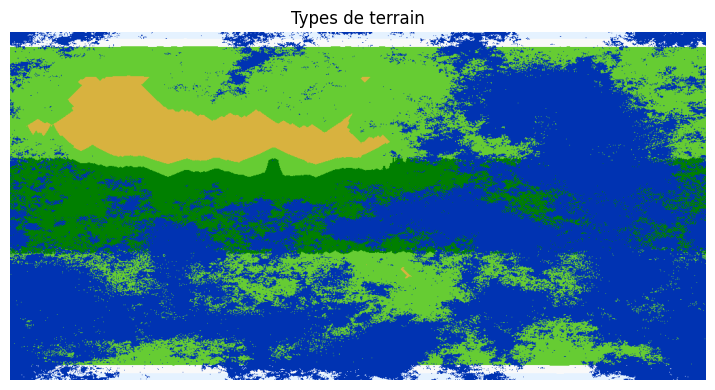

In [5]:
# === TERRAIN TYPE PREVIEW (masques bool corrigés) ===
H, W = water_mask.shape

# Masques pour l'indexation
sea_mask  = (water_mask == 1)
land_mask = ~sea_mask

terrain = np.full((H, W), 4, dtype=np.int32)   # 4 = Herbe par défaut
terrain[sea_mask] = 0                           # 0 = Océan

# Masques climatiques (bool plein format)
very_cold = (t < 0.12) & land_mask
cold      = (t < 0.20) & land_mask
wet       = (moist > 0.58) & land_mask & (~cold)
hot       = (t > 0.48) & land_mask
dry       = (moist < 0.32) & land_mask
desert    = hot & dry
high      = (elev_rel > 1500) & land_mask & (~cold)

# Priorité: glace > neige > désert > forêt > roche > herbe
terrain[very_cold] = 1
terrain[cold & (~very_cold)] = 2
terrain[desert] = 5
terrain[wet] = 3
terrain[high] = 6

# Palette & export
cmap = {
    0:(0.0,0.2,0.7), 1:(0.9,0.95,1.0), 2:(0.98,0.98,0.98),
    3:(0.0,0.5,0.0), 4:(0.4,0.8,0.2), 5:(0.85,0.7,0.25), 6:(0.55,0.55,0.55)
}
rgb = np.zeros((H,W,3), dtype=np.float32)
for code, col in cmap.items():
    rgb[terrain==code] = col

plt.figure(figsize=(10,4)); plt.imshow(rgb, origin='upper'); plt.axis('off')
plt.title('Types de terrain'); plt.tight_layout()
plt.savefig(out_dir/'terrain_preview.png', dpi=180); plt.show()

np.save(out_dir/'terrain_types.npy', terrain)

In [6]:
terrain = np.load(out_dir/'terrain_types.npy')
terrain

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [7]:
import pyvista as pv
from vtk.util.numpy_support import numpy_to_vtk

# --- image depuis ton terrain (catégories -> RGB) ---
cmap = {
    0:(0.0,0.2,0.7), 1:(0.9,0.95,1.0), 2:(0.98,0.98,0.98),
    3:(0.0,0.5,0.0), 4:(0.4,0.8,0.2), 5:(0.85,0.7,0.25), 6:(0.55,0.55,0.55)
}

H, W = terrain.shape
img = np.zeros((H, W, 3), dtype=np.float32)
for k, col in cmap.items():
    img[terrain == k] = col

img = (img * 255).astype(np.uint8)

# (option) si le nord est en haut de ton array, inverser verticalement pour l’UV v
img = np.flipud(img)

# --- sphère ---
sphere = pv.Sphere(radius=1.0, theta_resolution=img.shape[1], phi_resolution=img.shape[0])

# --- UV equirectangulaires (lon/lat) faits maison ---
P = sphere.points
x, y, z = P[:, 0], P[:, 1], P[:, 2]
r = np.linalg.norm(P, axis=1)
# longitude λ ∈ [-π, π], latitude φ ∈ [-π/2, π/2]
lon = np.arctan2(z, x)
lat = np.arcsin(np.clip(y / r, -1.0, 1.0))

u = (lon + np.pi) / (2*np.pi)      # 0..1
v = (lat + np.pi/2) / np.pi        # 0..1 (Sud->Nord). Inverse si nécessaire: v = 1 - v

uv = np.ascontiguousarray(np.c_[u, v].astype(np.float32))

# --- ⚠️ assigner comme TCoords VTK (clé pour ton erreur) ---
vtk_uv = numpy_to_vtk(uv, deep=True)
vtk_uv.SetNumberOfComponents(2)
vtk_uv.SetName('Texture Coordinates')
sphere.GetPointData().SetTCoords(vtk_uv)  # active officiellement les UV

# --- texture ---
tex = pv.numpy_to_texture(img)
tex.repeat = True
tex.interpolate = True

# --- rendu ---
plotter = pv.Plotter()
plotter.add_mesh(sphere, texture=tex, smooth_shading=True)
plotter.show()

Widget(value='<iframe src="http://localhost:58847/index.html?ui=P_0x17c22960a70_0&reconnect=auto" class="pyvis…